# Project Overview

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the [Perspective API](https://perspectiveapi.com/#/), including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this problem statement I am trying to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s [current](https://github.com/conversationai/unintended-ml-bias-analysis)  models.

The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

[This paper](https://arxiv.org/pdf/1610.08914.pdf) contains details about data creation.

# Problem Statement

Create a model better than [existing model](https://github.com/conversationai/unintended-ml-bias-analysis) to identify correctly weather a given comment is out of six categories defined above.


As this problem statement is taken from [kaggle](kaggle.com). [Source paper](https://arxiv.org/pdf/1610.08914.pdf) discuss the methodoly for model buidling. This paper achieved around 97 AUC. This paper is taken as baseline. 

In this [paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) auther has discussed NB-SVM based approach to classify text. First this approach is tried.
Later more sophisticated approaches using deep learning is tried and that really helped in improving the model accuracy.



# Metrics

*Area Under Curve (AUC)* of ROC curve is choosen as criteria to evaluate model performance.
Since there are six classes, accuracy is evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.

$${AUC = \frac{S_p - n_p(n_n +1)/2}{n_p n_n}}$$

where, Sp is the sum of the all positive examples ranked, while np and nn denote the number of
positive and negative examples respectively. 

As stated in [paper] (https://pdfs.semanticscholar.org/6174/3124c2a4b4e550731ac39508c7d18e520979.pdf) "The AUC was proven theoretically and empirically better than the accuracy metric for evaluating the classifier performance and discriminating
an optimal solution during the classification training." There auc is taken as accuracy metric.





# Data Exploration

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re,string
from scipy.sparse import hstack

from utils import *

%matplotlib inline

Using TensorFlow backend.


Load the train and test data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


We can see there are six classes and comment_text can be in more than one class.

In [4]:
print( "Number of Comments in Train and Test Data: ", len(train), len(test))

Number of Comments in Train and Test Data:  159571 153164


Number of observations in train and test are almost same. Lets see the number of clean comment in train data.
Number of clean comment in train data where each class will have value 0.

In [5]:
print( "Number of Clean Comments:" , sum(train.iloc[:,2:].sum(axis=1)==0))

Number of Clean Comments: 143346


Training data has lot of class imbalance, during trainig time this imbalance is taken care by weighing each class appropriately. Also since auc is choosen as metric criteria, imbalance will taken care automatically.

# Exploratory Analysis

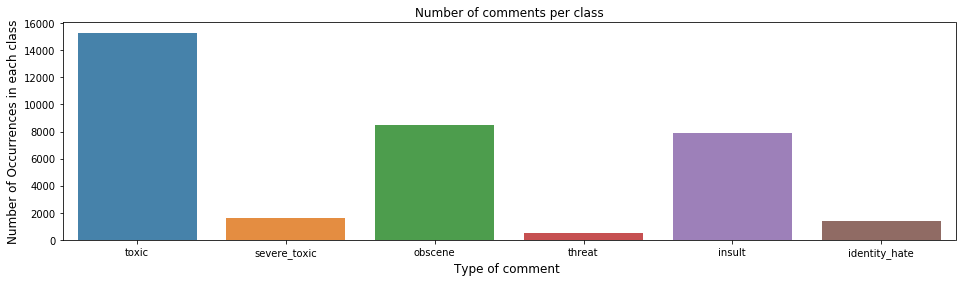

In [6]:
x=train.iloc[:,2:].sum()
plt.figure(figsize=(16,4))
ax= sns.barplot(x.index, x.values, alpha=0.9)

plt.title("Number of comments per class")
plt.ylabel('Number of Occurrences in each class', fontsize=12)
plt.xlabel('Type of comment ', fontsize=12)

rects = ax.patches
labels = x.values

plt.show()

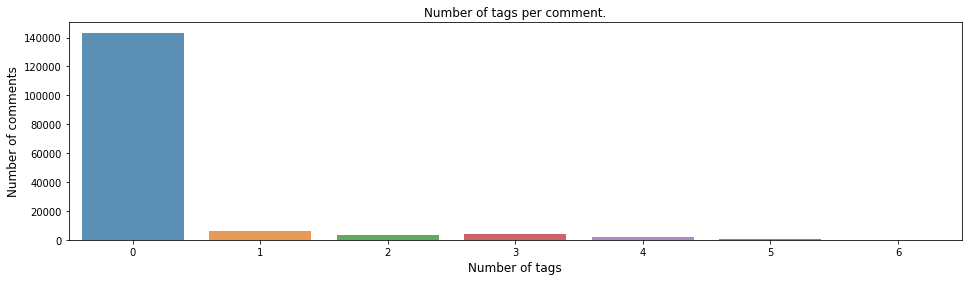

In [7]:
x=train.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number of tags per comment.")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

plt.show()

Above graph also shows the imbalance in data. Also there are comments which are associated with all the tags. It is multiclass classifcation where each comment can be in more than one class.

In [8]:
comment_lengths = train.comment_text.str.len()
print("comment length Mean, std, max:", comment_lengths.mean(), comment_lengths.std(), comment_lengths.max())


comment length Mean, std, max: 394.0732213246768 590.7202819048923 5000


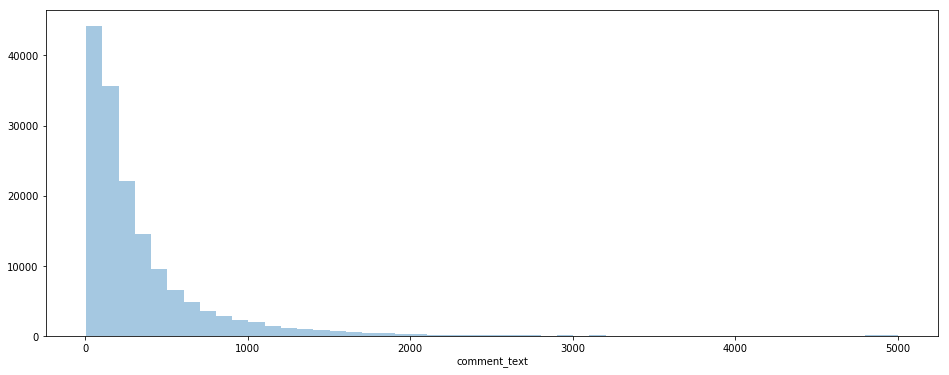

In [9]:
plt.figure(figsize=(16,6))
sns.distplot(comment_lengths, kde=False)

Length of comments vary alot. We might need to truncate the comment to appropriate length for modelling.

# Data Preprocessing

In [10]:
print(train[['comment_text']].isnull().sum(),test[['comment_text']].isnull().sum())

comment_text    0
dtype: int64 comment_text    0
dtype: int64


Also number of missing comments are null. So we don't need to worry about missing comment.



Lots of comments are not properly formatted therefore comments need cleaning. First some slangs are properly mapped using below dictionary.

In [11]:
repl = {
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " frown ",
    ":(": " frown ",
    ":s": " frown ",
    ":-s": " frown ",
    "&lt;3": " heart ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":&gt;": " angry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "it's" : "it is",
    "'s" : " is",
    "that's" : "that is",
    "weren't" : "were not",
}

In [12]:
keys = [i for i in repl.keys()]

new_train_data = []
new_test_data = []
ltr = train["comment_text"].tolist()
lte = test["comment_text"].tolist()
    
for i in ltr:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            j = repl[j]
        xx += j + " "
    new_train_data.append(xx)
    
for i in lte:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            j = repl[j]
        xx += j + " "
    new_test_data.append(xx)
    
    
train["new_comment_text"] = new_train_data
test["new_comment_text"] = new_test_data

In [13]:
trate = train["new_comment_text"].tolist()
tete = test["new_comment_text"].tolist()

for i, c in enumerate(trate):
    trate[i] = re.sub('[^a-zA-Z ?!]+', '', str(trate[i]).lower())
for i, c in enumerate(tete):
    tete[i] = re.sub('[^a-zA-Z ?!]+', '', tete[i])
    
train["comment_text"] = trate
test["comment_text"] = tete
    
del trate, tete

train.drop(["new_comment_text"], axis=1, inplace=True)
test.drop(["new_comment_text"], axis=1, inplace=True)

# Word Vectorization/ Feature Creation

Features are created for applying NB-SVM as metioned in [paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). I have create ngram feature that is unigram and bigram. Also used charater tokenizaiton features.

In [14]:
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

Word and character tokens are generated using both test and train data to have good performance of model. 

From sklearn library [vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is used with following parameters:

 * Unigram and Bigram Model
 * Both word and char tokens are created.
 * Using idf reweighing to avoid biasing toward most frequent word like the.
 * Smooth_idf is used to prevent division by zero.
 * Using sublinear scaling.
 * Number of features created are 10000.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# To remove punctuations.
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()


word_vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,analyzer='word',
                                  strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1,max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

Character tokens are also generated. With same parameter as word but number features equal 50000.

In [16]:
char_vectorizer = TfidfVectorizer(ngram_range=(2,6), analyzer='char',  
                                  strip_accents='unicode',use_idf=1, smooth_idf=1,sublinear_tf=1,
                                  stop_words='english', max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

Combine word tokens with char tokens

In [17]:
train_features = hstack([train_char_features, train_word_features]).tocsr()
test_features = hstack([test_char_features, test_word_features]).tocsr()

Divide the data into train and validation set [using](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to check the accuracy of model.

In [18]:
from sklearn.model_selection import train_test_split

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_train, X_val, y_train, y_val = train_test_split(train_features, train[class_names], test_size=0.2, random_state=1)


# Modelling

## 1. NB-SVM Model

In [19]:
from sklearn.metrics import roc_auc_score

preds_val = np.zeros((X_val.shape[0], len(class_names)))
preds_test = np.zeros((len(test),len(class_names)))

auc = np.zeros((len(class_names)))

# C is hyperparameter we tuned using cross validation and chose 4.

for i, j in enumerate(class_names):
    model = NbSvmClassifier(C=4, dual=True, n_jobs=1).fit(X_train, y_train[j])
    preds_val[:,i] = model.predict_proba(X_val)[:,1]  
    auc[i] = roc_auc_score(y_val[j], preds_val[:,i])
    print('\n class %s AUC: %.6f' % ( j, auc[i]))
    
    preds_test[:,i] = model.predict_proba(test_features)[:,1] # to test on kaggle.
    
print('\n Average AUC:\t%.6f' % (np.mean(auc)))


 class toxic AUC: 0.978385

 class severe_toxic AUC: 0.983605

 class obscene AUC: 0.989263

 class threat AUC: 0.978733

 class insult AUC: 0.980809

 class identity_hate AUC: 0.971795

 Average AUC:	0.980432


Accuracy on validation set is quiet impressive but final accuracy will be based on test data. Accuracy for test data is directly tested on kaggle because ground truth was not provided. It turned out to be **0.9769**. Which is not much improvement over base model. Therefore pure logistic method is applied with better tuning of parameters. 

Also as we have seen there is class imbalance in data. During logistic regression model I have taken care of that using balanced class.


## 2. Logistic Regression

In [20]:
## Parameter tuned using cross validation with five folds for all sexi classes.

all_parameters = {'C'             : [1.048113, 0.1930, 0.596362, 0.25595, 0.449843, 0.25595],
                  'tol'           : [0.1, 0.1, 0.046416, 0.0215443, 0.1, 0.01]}

preds_val_log = np.zeros((X_val.shape[0], len(class_names)))
preds_test_log = np.zeros((len(test),len(class_names)))
auc = np.zeros((len(class_names)))

for i, j in enumerate(class_names):

    classifier = LogisticRegression(C=all_parameters['C'][i],
    max_iter=200, tol=all_parameters['tol'][i],
    solver='newton-cg',
    fit_intercept= True,
    penalty= "l2",
    dual=False,
    class_weight='balanced',
    verbose=0)

    classifier.fit(X_train, y_train[j])
    preds_val_log[:,i] = classifier.predict_proba(X_val)[:,1]  
    auc[i] = roc_auc_score(y_val[j], preds_val_log[:,i])
    print('\n class %s AUC: %.6f' % ( j, auc[i]))
    
    preds_test_log[:,i] = classifier.predict_proba(test_features)[:,1] # to test on kaggle.

print('\n Average AUC:\t%.6f' % (np.mean(auc)))




 class toxic AUC: 0.977023

 class severe_toxic AUC: 0.987943

 class obscene AUC: 0.988342

 class threat AUC: 0.987617

 class insult AUC: 0.981774

 class identity_hate AUC: 0.980361

 Average AUC:	0.983843


Accuracy for test data is directly tested on kaggle because ground truth was not provided. It turned out to be **0.9802**. It is good improvement. 
Reason for improvements:
* Better tuning of hyper parameters. Using train and val set.
* Using balanced class while training. That will multiply each class with inverse of frequency.

To further improve the accuracy deep learning model is tried and that model gave better accuracy than above two model.

## 3. Deep Learning 

NLP using deeplearning has mostly following steps as discussed in [this blog](https://explosion.ai/blog/deep-learning-formula-nlp) very nicely:
* Embedding
* Encode
* Attend
* Predict

Keras is used for training the model.

In [14]:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D,AveragePooling1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

### Embedding:
For embedding glove weights are used which are available online [here](https://nlp.stanford.edu/projects/glove/).

In [15]:
# glove embedding weights are used.
EMBEDDING_FILE = 'glove.840B.300d.txt'

In [16]:
max_features=100000 # Maximum number of features chosen.
maxlen=150 # As we have seen lenght of comments have lots of variation, I have chosen 150 as maximum length.
embed_size=300

In [17]:
X_train = train["comment_text"].str.lower()
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].str.lower()

In [18]:
token=text.Tokenizer(num_words=max_features,lower=True) # Tokenizer feature of keras.

token.fit_on_texts(list(X_train)+list(X_test)) # Again token are generated using test and train data set both.

X_train=token.texts_to_sequences(X_train) # This will convert comments into sequence of words(tokens)
X_test=token.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(X_train,maxlen=maxlen) # Padding zero for small comments and trimming bigger comment to size 150
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [19]:
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [20]:
#preparing  embedding matrix

word_index = token.word_index
num_words = min(max_features, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Encoding + Attention
Lots of hyperparameters are tried. Finally following architecture is used on training.

In [21]:
from utils import *

input_comment = Input(shape=(maxlen,), dtype='int32')
x=  Embedding(max_features, embed_size, weights=[embedding_matrix],input_length=maxlen,trainable=False)(input_comment)

x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.15,recurrent_dropout=0.15))(x)

x = Conv1D(64, kernel_size = 3, padding = "same", kernel_initializer = "glorot_uniform")(x)

avg_pool = AveragePooling1D(strides=1,padding='same')(x)
max_pool = MaxPooling1D(strides=1,padding='same')(x)
x = concatenate([avg_pool, max_pool]) 

merged = Attention(maxlen)(x)
merged = BatchNormalization()(merged)

preds = Dense(6, activation='sigmoid')(merged)


In [22]:
model = Model(inputs=[input_comment],outputs=preds)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3),  metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 150, 300)      30000000    input_1[0][0]                    
____________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDrop (None, 150, 300)      0           embedding_1[0][0]                
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 150, 256)      329472      spatial_dropout1d_1[0][0]        
___________________________________________________________________________________________

In [24]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=1)
best_model_path ="weights-best_model.hdf5"

early_stopping =EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)

callbacks_list = [ra_val,model_checkpoint, early_stopping]

/datadrive/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Predict


In [25]:
model.fit(X_tra, y_tra, validation_data=(X_val, y_val),  epochs=20, batch_size=256, shuffle=True,callbacks= callbacks_list)
model.load_weights(best_model_path)

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127488/127656 [============================>.] - ETA: 0s - loss: 0.1742 - acc: 0.9600
 ROC-AUC - epoch: 1 - score: 0.975035
127656/127656 [==============================] - 274s - loss: 0.1740 - acc: 0.9600 - val_loss: 0.0694 - val_acc: 0.9776
Epoch 2/20
127488/127656 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9820
 ROC-AUC - epoch: 2 - score: 0.984541
127656/127656 [==============================] - 270s - loss: 0.0499 - acc: 0.9820 - val_loss: 0.0467 - val_acc: 0.9825
Epoch 3/20
127488/127656 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9828
 ROC-AUC - epoch: 3 - score: 0.985391
127656/127656 [==============================] - 272s - loss: 0.0457 - acc: 0.9828 - val_loss: 0.0436 - val_acc: 0.9835
Epoch 4/20
127488/127656 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9833
 ROC-AUC - epoch: 4 - score: 0.986576
127656/127656 [==============================] - 

In [26]:
X_test = model.predict([x_test], batch_size=1024, verbose=1)

153164/153164 [==============================] - 33s    


Deep learning model proved to be better than other two models. Accuracy on kaggle data based on this model was **0.9859**. Which was quite a improvement.

## Results


Deep learning model proved to be a great way to approach NLP problem. Advantage of deep lerning model is that it doesn't required much feature engineering. Also it is more generalizable.
Order of accuracy on kaggle private data:

* NB-SVM  : 0.9769
* Logisitc: 0.9802
* DeepLearning: 0.9859

Each model performance is validated on valdiation set as shown above.
Generalisability of model is can be justified by seeing the accuracy of model on unseen data on kaggle.



** Final model is good improvement over baseline model and can be used for the toxic comments classifications.**

## Conclusion /Future Work

- It is shown that deep learning can be quite effective in solving NLP task like comment classifications.
- Accuracy of model can be further improved with better architecture and more data for training compare to provide in kaggle.
- Accuracy can be enhanced further with embsebling of different results.